## Which city in Taiwan?

The following notebook is taken from the fast.ai Practical Deep Learning course notebook 'is it a bird?'
I've edited it to do my own learning and tuning.

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.2 MB/s eta 0:00:00


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "Taipei photos"
1. Use DuckDuckGo to search for images of "Kaohsiung photos"
2. Repeat for other cities
1. Fine-tune a pretrained neural network to recognise these groups
1. Try running this model on some sample pictures and see if it works.

## Step 1: Download sample images

In [3]:
# define our search utility function
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a picture of Taipei. First we search images and get the URLs, then download one and verify it. If it's valid then we take a look at it and its corresponding URL.

http://3.bp.blogspot.com/-hie64kN-X6Q/VuY9fubHeoI/AAAAAAAAuUs/pAAC3oSrZOYJ4YgnidMluGcmVDvNveZsg/s1600/elephant-mountain-taipei-101.jpg


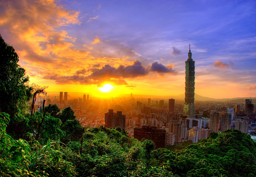

In [4]:
from fastai.vision.all import *
from fastdownload import download_url
# Note: it appears Chinese characters work for search, but not for reading files. Probably just an encoding error.

search = 'Taipei'
urls = search_images(f'{search} photos', max_images=10)
dest = f'{search}.jpg'

for u in urls:
    download_url(u, dest, show_progress=False)
    if verify_images([dest]) == []:
        print(u)
        break

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Kaohsiung photos":

https://www.cktravels.com/wp-content/uploads/2019/05/DSC04000-2.jpg


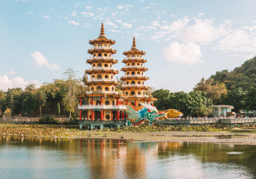

In [5]:
search = 'Kaohsiung'
urls = search_images(f'{search} photos', max_images=10)
dest = f'{search}.jpg'

for u in urls:
    download_url(u, dest, show_progress=False)
    if verify_images([dest]) == []:
        print(u)
        break

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

The searches appear to be working, so let's go ahead and continue for other cities in Taiwan, and save them to folders.

In [6]:
%%time

searches = 'Taipei', 'Kaohsiung', 'Tainan', 'Chiayi', 'Taichung', 'Hualien', 'Taitung'
# remember to change the base path if I run this multiple times, since that's where the model looks for training by default.
# be careful running locally, it will download 200 pictures per search term.
base_path = Path('taiwan_cities')

for city in searches:
    dest = (base_path/city)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{city} photo'))
    time.sleep(5)
    resize_images(base_path/city, max_size=400, dest=base_path/city)

CPU times: user 8.02 s, sys: 3.33 s, total: 11.3 s
Wall time: 5min


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(base_path))
failed.map(Path.unlink)
len(failed)

43

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

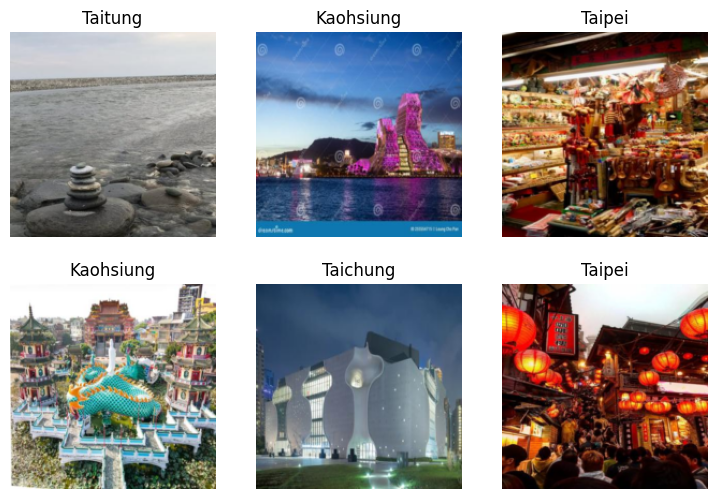

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(base_path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

The original notebook had a fine tuning of 3 epochs, but only had 2 categories. I'm trying to tell between 7 different cities, so I'm arbitrarily trying out 10 epochs.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.799433,2.031317,0.619048,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.714313,1.831796,0.583333,00:02
1,1.416924,1.796402,0.507937,00:02
2,1.034108,1.849827,0.480159,00:03
3,0.706574,2.031383,0.507937,00:02
4,0.464320,2.102588,0.511905,00:02
5,0.298747,2.101148,0.496032,00:02
6,0.193020,2.120759,0.511905,00:02
7,0.127823,2.135357,0.468254,00:02
8,0.088876,2.117859,0.488095,00:02
9,0.068618,2.131525,0.484127,00:02


Resnet18 is already a trained image recognition model, so we're just fine-tuning the pretrained model. Considering our categories are actually quite similar, only having a <2% error rate is pretty good!
(For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).)

## Step 3: Use the trained model

Let's download some random images and see how our model performs. I suspect that it is learning to differentiate landmarks, and other stereotypical photos for each place. On the one hand that's a 'shortcut' and we might like it to legitimately learn to differentiate each place, on the other hand that's exactly what people would do: if you see a photo with Taipei 101 in the skyline, it's probably Taipei.

Search was: Taipei
Prediction is: Taipei
Probability: tensor([1.2725e-04, 3.3957e-05, 7.3848e-06, 1.0874e-04, 5.2383e-05, 9.9967e-01,
        2.0911e-06])


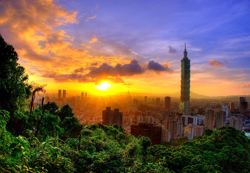

Search was: Taipei 101
Prediction is: Taipei
Probability: tensor([5.8688e-07, 1.2873e-04, 5.6012e-04, 2.9891e-06, 2.0400e-07, 9.9931e-01,
        2.2747e-06])


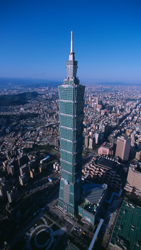

Search was: Fort Zeelandia Tainan
Prediction is: Tainan
Probability: tensor([3.4814e-06, 3.7964e-04, 3.1539e-05, 7.4879e-05, 9.9950e-01, 7.6371e-06,
        5.5511e-06])


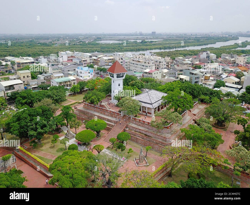

Search was: Tainan city
Prediction is: Tainan
Probability: tensor([6.1961e-06, 2.7555e-06, 1.7977e-06, 3.4726e-06, 9.9979e-01, 1.9585e-04,
        2.8144e-06])


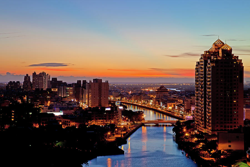

Search was: 85 Sky Tower
Prediction is: Kaohsiung
Probability: tensor([4.4039e-04, 2.2855e-06, 9.9816e-01, 3.7977e-05, 2.9462e-04, 9.4429e-04,
        1.2223e-04])


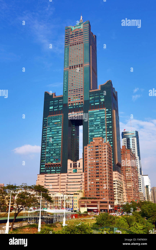

Search was: Kaohsiung City
Prediction is: Kaohsiung
Probability: tensor([9.8805e-04, 3.5320e-04, 6.4809e-01, 1.6142e-02, 1.5557e-04, 3.3392e-01,
        3.4877e-04])


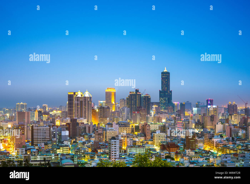

Search was: Dulan Taitung
Prediction is: Hualien
Probability: tensor([1.1302e-02, 5.3197e-01, 8.2890e-03, 8.3954e-03, 2.4758e-04, 9.2833e-04,
        4.3887e-01])


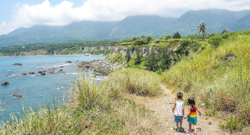

Search was: Taitung City
Prediction is: Taitung
Probability: tensor([8.2160e-06, 8.1150e-06, 1.5099e-05, 1.9120e-04, 1.0669e-04, 4.7329e-05,
        9.9962e-01])


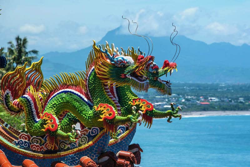

Search was: Taroko Gorge
Prediction is: Hualien
Probability: tensor([2.9563e-03, 9.9701e-01, 3.9280e-07, 2.5365e-06, 1.5726e-05, 1.4777e-05,
        7.0983e-07])


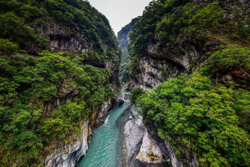

Search was: Hualien City
Prediction is: Hualien
Probability: tensor([8.2958e-04, 7.5409e-01, 7.1814e-05, 6.8739e-02, 1.5246e-03, 1.1465e-05,
        1.7473e-01])


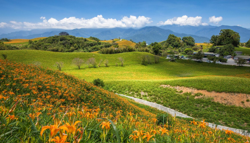

Search was: Chiayi
Prediction is: Chiayi
Probability: tensor([9.9910e-01, 1.9443e-05, 5.8766e-05, 7.0709e-05, 2.1072e-05, 3.1213e-05,
        6.9623e-04])


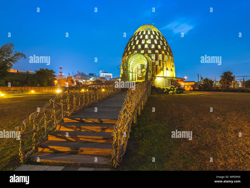

Search was: New York City
Prediction is: Taipei
Probability: tensor([8.2896e-05, 3.1089e-05, 1.0267e-03, 2.7953e-03, 3.9030e-04, 9.9567e-01,
        3.0140e-06])


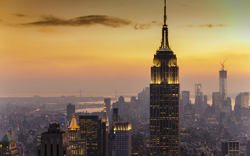

Search was: Taiwan Yushan
Prediction is: Hualien
Probability: tensor([1.2258e-02, 9.5867e-01, 1.3070e-04, 3.8982e-04, 1.9657e-02, 6.8279e-04,
        8.2123e-03])


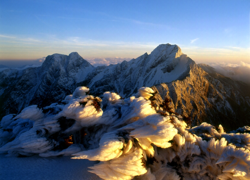

Search was: White sand beach
Prediction is: Taitung
Probability: tensor([0.0624, 0.0588, 0.1513, 0.0019, 0.0062, 0.0706, 0.6487])


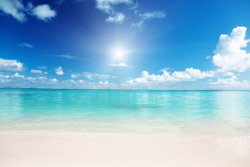

In [10]:
test_searches = 'Taipei', 'Taipei 101', 'Fort Zeelandia Tainan', 'Tainan city', '85 Sky Tower', 'Kaohsiung City', 'Dulan Taitung', 'Taitung City', 'Taroko Gorge', 'Hualien City', 'Chiayi', 'New York City', 'Taiwan Yushan', 'White sand beach'

for test in test_searches:
    dest = f'{test}.jpg'
    urls = search_images(f'{test} photos', max_images = 5)
    for u in urls:
        try:
            download_url(u, dest, show_progress=False)
        except:
            continue
        if verify_images([dest]) == []:
            break
    pil = PILImage.create(dest)
    is_city, _, probs = learn.predict(pil)
    print(f"Search was: {test}")
    print(f"Prediction is: {is_city}")
    print(f"Probability: {probs}")
    pil.thumbnail((250,250))
    display(pil)
    print("")

Good job, resnet18. :)

As we can see, the classifier is mostly correct, only tripping up on the 'Dulan' image. From our last few tests we can see that this is because it's not really learning the city specifics, but just what is associated with each city. Taipei 101, 85 Sky Tower, Fort Zeelandia, and Taroko gorge are expected landmarks for each of their associated places. However Hualien and Taitung are usually where people go for mountains and beaches, and a city with lots of towers is probably Taipei. Still, if we were trying to differentiate cities in Taiwan, we wouldn't expect someone to ask about 'New York City'!

As an addendum, I'm not actually sure if the pictures I tested with were used in training or not. Best practices would be to ensure that they are separate, maybe by searching for 200 + x photos during training, and setting the x aside for post-training tests.

This was a nice test of fast.ai and resnet's capabilities, and was quite easy and quick. Cool!